# Categorisez automatiquement des questions - Exploration

In [1]:
%%script echo skipping
from google.colab import drive
drive.mount('/content/drive')

skipping


# SOMMAIRE
* [PREPARATION](#PREPARATION)
* [CHARGEMENT](#CHARGEMENT)
* [Monogram](#Monogram)
    * [BAG OF WORDS](#BAG-OF-WORDS)
    * [TF-IDF](#TF-IDF)
        * [Bodies](#Bodies)
        * [Titles](#Titles)
        * [Pondere](#Pondere)
        * [Bodies+titles](#Bodies+titles)
    * [REDUCTION DIMENSIONNELLE - ACP](#REDUCTION-DIMENSIONNELLE---ACP)
    * [CLUSTERING](#CLUSTERING)
* [Bi-grams](#Bi-grams)
* [Tri-grams](#Tri-grams)
*[Tags](#Tags)
    * [Classement-TF-IDF](#Tags)
    * [Labellisation](#Labellisation)
*[Modelisation](#Modelisation)
    * [Bayes naïf](#Bayes-naïf)
    * [Random forest](#Random-forest)
* [LDA](#LDA)

# PREPARATION

## Import des librairies

In [2]:
import joblib
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib import cm #colormap
import numpy as np

import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import cluster, metrics
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import r2_score, accuracy_score

from sklearn.manifold import TSNE

from collections import Counter

## Paramétrage du notebook

In [3]:
from matplotlib import font_manager

font_dirs = ['/Library/Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Comic Sans'
plt.rcParams['font.sans-serif'] = 'Franklin Gothic Book'

In [4]:
sns.set(rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

#mplt.font_manager._rebuild()
#mplt.font_manager.findfont('Franklin Gothic Book',rebuild_if_missing=True)


pd.options.display.max_colwidth=200
pd.options.display.min_rows=25
pd.options.display.max_columns=50

## Declaration des fonctions

In [99]:
def count_words(list):
    # create counter and run through all data
    counter = Counter()
    freq = Counter(list) 
    return freq

def bow(documents):
    cv=CountVectorizer()
    cv.fit(documents)
    vector=cv.transform(documents)
    dfBOW=pd.DataFrame(data=vector.toarray(),columns=cv.get_feature_names_out())
    return dfBOW
def confusionMatrixAcc(y_true, y_pred):
    """
    Fonction qui retourne la matrice de confusion

    Parameters
    ----------
    y_true : pandas Series
        une Serie de valeurs (labels) reelles
    y_pred : pandas Series
        une Serie de valeurs (labels) predites
    Returns
    -------
    confusionMatrix : DataFrame
        la matrice de confusion
    """

    dfConfusion=pd.crosstab(y_test, y_pred_test,rownames=['Reel'], colnames=['Predit'], margins=False)
    confusionMatrix=pd.DataFrame()

    for c in dfConfusion.columns:
        TP=dfConfusion.loc[c,c]
        FP=dfConfusion.loc[:,c].sum()-dfConfusion.loc[c,c]
        TN=np.diagonal(dfConfusion).sum()-dfConfusion.loc[c,c]
        FN=dfConfusion.loc[c,:].sum()-dfConfusion.loc[c,c]
        TPR=TP/(TP+FN) # taux de vrai positif
        FPR=FP/(FP+TN) # taux de faux positifs
        Accuracy=(TP+TN)/(TP+FP+TN+FN)
        confusionMatrix=pd.concat([confusionMatrix,
        pd.DataFrame({
            'Class':c,
            'TP':[TP],
            'FP':[FP],
            'TN':[TN],
            'FN':[FN],
            'TPR':[TPR],
            'FPR':[FPR],
            'Accuracy':[Accuracy]})
            ])
    
    confusionMatrix.reset_index(drop=True,inplace=True)
    confusionMatrix=confusionMatrix.sort_values('Accuracy',ascending=False)
    return confusionMatrix

# CHARGEMENT

In [6]:
#dfCleaned=joblib.load("drive/MyDrive/Colab Notebooks/Datasets/dfCleaned.jbl.bz2")
dfCleaned=joblib.load('dfCleaned2000.jbl.bz2')

In [7]:
dfCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 43576 to 48725
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        2000 non-null   object
 1   Body         2000 non-null   object
 2   Tags         2000 non-null   object
 3   BodyLemmas   2000 non-null   object
 4   TitleLemmas  2000 non-null   object
dtypes: object(5)
memory usage: 93.8+ KB


In [8]:
dfCleaned.sample(8)

,Title,Body,Tags,BodyLemmas,TitleLemmas
37925,how to handle db schema updates when using schemabinding and updating often,<p>i'm using a ms sql server db and use plenty of views (for use with an o/r mapper). a little annoyance is that i'd like to </p>\n\n<ul>\n<li>use schema binding</li>\n<li>update with scripts (to ...,sql-server code-generation version-control,"[use, m, sql, server, use, plenty, view, use, mapper, little, annoyance, like, use, schema, binding, script, deploy, server, put, source, control, system, run, issue, whenever, want, column, first...","[handle, db, schema, update, use, schemabinding, update, often]"
23933,read exif online without need to upload photos,<p>i have an html5 site. i want to do following thing:</p>\n\n<ol>\n<li>walk through files in a folder </li>\n<li>find all images </li>\n<li>get exif file from images </li>\n<li>analyze an exifs (...,html exif,"[html, site, want, follow, thing, walk, file, folder, find, image, get, exif, file, image, analyze, exifs, server, correct, exifs, best, scenario, conscious, step, possibly, do, select, file, user...","[read, exif, online, without, need, upload, photo]"
694,do i need locks anytime i read other classes' fields in a multithread app?,<p>i am writing a game server and i am not exactly sure if i need to lock even things like that:</p>\n\n<pre><code> public string name\n {\n get { return this.pname; }\n ...,c# multithreading,"[write, game, server, ex, sure, need, lock, even, thing, like, public, string, name, get, return, pname, protect, set, pname, value, example, npc, class, public, virtual, void, player, int, dmg, p...","[need, lock, anytime, read, class, field, multithread, app]"
35848,what does this code do? delphi asm,"<p>i try to parse encrypted &amp;rq history, but i really can't understand asm code. it is embedded to delphi function.</p>\n\n<p>can somebody help me to understand this? </p>\n\n<pre><code>proced...",assembly,"[try, parse, encrypt, amp, rq, history, really, understand, asm, code, embe, delphi, function, somebody, help, understand, procedure, decritt, var, string, key, integer, asm, mov, ecx, key, mov, d...","[code, delphi, asm]"
3274,cakephp could not find validation handler,"<p>i'm struggeling with my cakephp validation</p>\n\n<p>scenario:\nin my db i have one table ""alliances"" and one ""federations"". in ""federations"" connections between alliances are stored. ""alliance...",php validation cakephp model,"[struggeling, vali, scenario, one, alliance, one, federation, federation, connection, alliance, store, alliance, get, stupid, col, like, id, name, etc, federation, like, id, type, fk, alliance, ty...","[cakephp, could, find, validation, handler]"
12329,how to start capturing data from a specific row(say a8) value using userform,"<p><a href=""https://i.stack.imgur.com/im6fc.jpg"" rel=""nofollow noreferrer"">desired output should start from a8 row</a>i want to start capturing the data from a particular row range say <code>a8</c...",vba excel,"[href, http, st, imgur, com, im, jpg, rel, nofollow, noreferrer, desire, output, start, row, want, start, particular, row, range, say, continue, next, row, code, get, error, select, range, anyone,...","[start, capture, data, specific, row, say, a8, value, use, userform]"
18737,swift – uitabbar.appearance().bartintcolor not working in simulator,<p>here is my code:</p>\n\n<pre><code>import uikit\n\nclass tabbarviewcontroller: uitabbarcontroller {\n\n override func viewdidload() {\n super.viewdidload()\n uitabbar.appearanc...,ios swift uitabbarcontroller ios-simulator,"[code, import, uikit, class, uit, override, func, viewdidlo, super, viewdidlo, uit, appearance, uicolor, run, work, perfectly, real, device, set, color, correctly, code, run, iphone, simulator, re...","[swift, uitabbar, appearance, bartintcolor, work, simulator]"
43063,seam - ejb3 in web module/war?,"<p>i'm writing an application using seam 2.2.x which will be deployed on jboss 5.1. i have an ejb module with all of the business 

In [9]:
bodies=dfCleaned['BodyLemmas'].map(' '.join)
titles=dfCleaned['TitleLemmas'].map(' '.join)

# Pour tenir compte des titres, on les concatene aux corps de message
dfCleaned['BodyTitleLemmas']=dfCleaned['BodyLemmas']+dfCleaned['TitleLemmas']
bodies_titles=dfCleaned['BodyTitleLemmas'].map(' '.join)

# BAG OF WORDS

In [10]:
dfBowBodies=bow(bodies)
nBowBodies=dfBowBodies.to_numpy() # optimisation des calculs en passant par numpy

dfBowTitles=bow(titles)
nBowTitles=dfBowTitles.to_numpy() # optimisation des calculs en passant par numpy

In [11]:
%%time
dfSumBowBodies=pd.DataFrame(data=nBowBodies.sum(axis=0))
dfSumBowBodies.index=dfBowBodies.columns
dfSumBowBodies.columns=['count']

dfSumBowTitles=pd.DataFrame(data=nBowTitles.sum(axis=0))
dfSumBowTitles.index=dfBowTitles.columns
dfSumBowTitles.columns=['count']

dfSumBowTitlesHead=dfSumBowTitles.sort_values(by='count',ascending=False).head(25)
dfSumBowBodiesHead=dfSumBowBodies.sort_values(by='count',ascending=False).head(25)

CPU times: user 78.9 ms, sys: 32.8 ms, total: 112 ms
Wall time: 110 ms


In [12]:
from IPython.display import display_html 


df1_styler = dfSumBowTitlesHead.style.set_table_attributes("style='display:inline'").set_caption('dfSumBowTitlesHead')
df2_styler = dfSumBowBodiesHead.style.set_table_attributes("style='display:inline'").set_caption('dfSumBowBodiesHead')

space = "\xa0" * 10
display_html(df1_styler._repr_html_()+ space  + df2_styler._repr_html_(), raw=True)

,count
use,202
file,122
get,99
error,85
value,73
work,68
array,65
string,64
android,61
data,59


# Monogram

## TF-IDF

In [13]:
# Initialisation du vectoriseur TF IDF de scikit learn
vectorizer= TfidfVectorizer()

### Bodies

In [14]:
response= vectorizer.fit_transform(bodies)
dfTFIDF_bodies=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies=dfTFIDF_bodies.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - bodies classement des mots')]

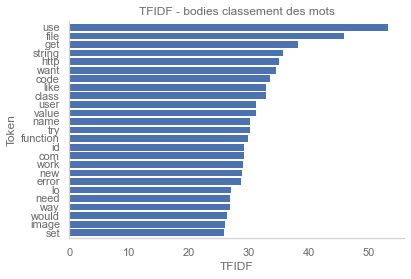

In [15]:
ax = sortedTFIDF_bodies.head(25).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - bodies classement des mots')

### Titles

In [16]:
%%time
response= vectorizer.fit_transform(titles)
dfTFIDF_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_titles=dfTFIDF_titles.sum(axis=0).sort_values(ascending=False)

CPU times: user 83.7 ms, sys: 22.3 ms, total: 106 ms
Wall time: 105 ms


[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - titles - classement des mots')]

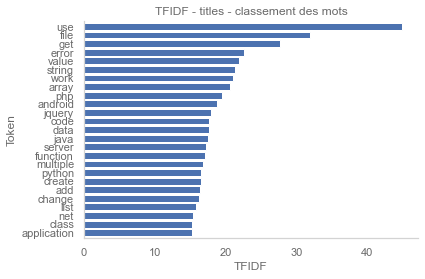

In [17]:
ax = sortedTFIDF_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - titles - classement des mots')

In [18]:
dfTFIDF_titles.shape,dfTFIDF_bodies.shape

((2000, 3044), (2000, 14975))

### Pondere

TF-IDF (Pondéré) = TF-IDF(title) * alpha + TF-IDF(body) * (1-alpha)  
par ex. avec alpha=0.8

In [19]:
commonTokens=list(set(dfTFIDF_titles.columns) & set(dfTFIDF_bodies.columns))
dfTFIDFCommon=dfTFIDF_titles[0:10000][commonTokens]*0.8+dfTFIDF_bodies[0:10000][commonTokens]*0.2
sortedTFIDFCommon=dfTFIDFCommon.sum(axis=0).sort_values(ascending=False)

In [20]:
dfTFIDFCommon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2296 entries, fit to wix
dtypes: float64(2296)
memory usage: 35.0 MB


<AxesSubplot:>

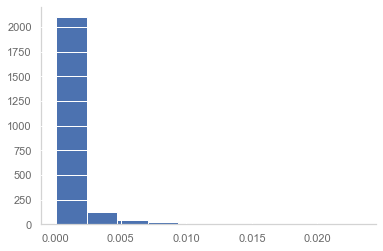

In [21]:
dfTFIDFCommon.mean(axis=0).hist()

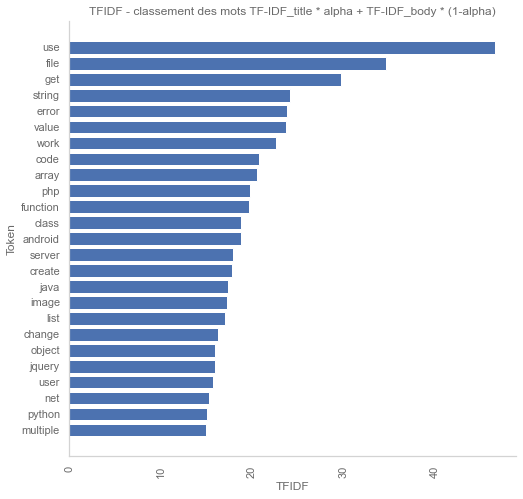

In [22]:
plt.figure(figsize=(8,8))

plt.barh(sortedTFIDFCommon.head(25).index,sortedTFIDFCommon.head(25).values)
plt.gca().invert_yaxis()

plt.xlabel("TFIDF")
plt.xticks(rotation='vertical')

plt.ylabel("Token")
plt.title("TFIDF - classement des mots TF-IDF_title * alpha + TF-IDF_body * (1-alpha)")
plt.show()

In [23]:
X=dfTFIDFCommon.values
X.shape

(2000, 2296)

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


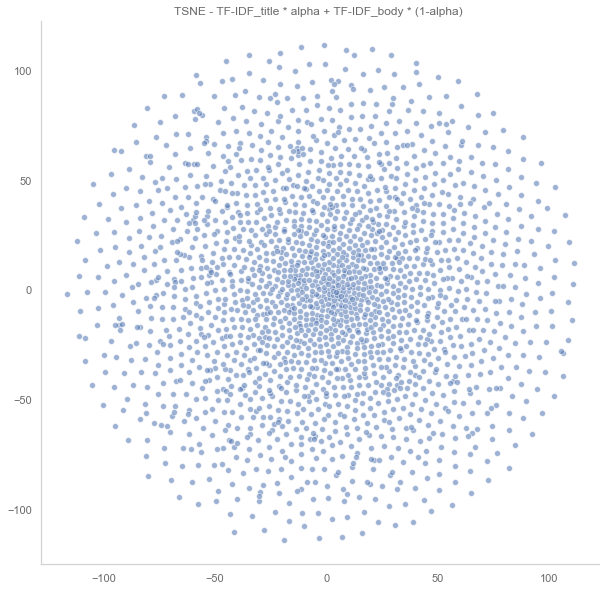

In [24]:
#%%time
tsne = TSNE(random_state=1, method='barnes_hut',n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) ')
plt.show()

### Bodies+titles

In [25]:
%%time
response= vectorizer.fit_transform(bodies_titles)
dfTFIDF_bodies_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies_titles=dfTFIDF_bodies_titles.sum(axis=0).sort_values(ascending=False)

CPU times: user 528 ms, sys: 99.9 ms, total: 628 ms
Wall time: 628 ms


[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - bodies_titles - classement des mots')]

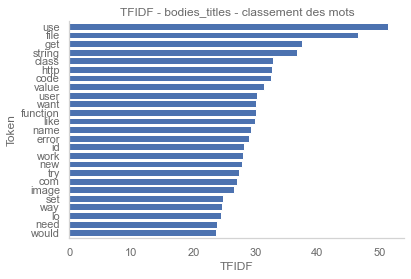

In [26]:
ax = sortedTFIDF_bodies_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - bodies_titles - classement des mots')

Le calcul de TFIDF sur les corps et titres de message concaténés donne le même classement que pour le TFIDF sur les corps seuls.  
On preferera donc le TFIDF pondéré sur les titres et corps: TF-IDF_title * alpha + TF-IDF_body * (1-alpha).

In [27]:
X=dfTFIDF_bodies_titles.values

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


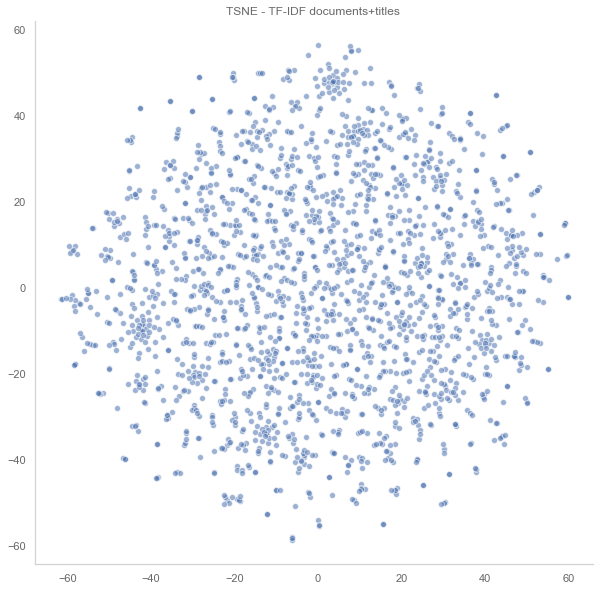

In [28]:
#%%time
tsne = TSNE(random_state=1, method='barnes_hut',n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF documents+titles ')
plt.show()

des regroupements semblent apparaitre sur la visualisation TSNE, voyons le score de silhouette/nombre de clusters obtenu par clustering K-Means

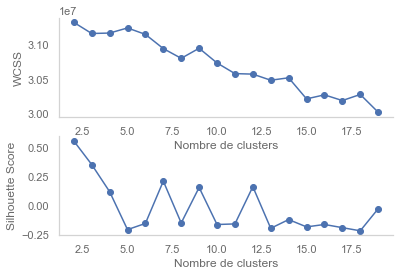

CPU times: user 12min 32s, sys: 14.6 s, total: 12min 47s
Wall time: 1min 15s


In [29]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)

for n in range(2,20):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(XCentreReduit)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(XCentreReduit,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

Le score de silhouette <0.25 au dela de 2 clusters.  
Le clustering KMeans n'est pas concluant pour les titres et corps de messages concaténés.

## REDUCTION DIMENSIONNELLE - ACP

<AxesSubplot:>

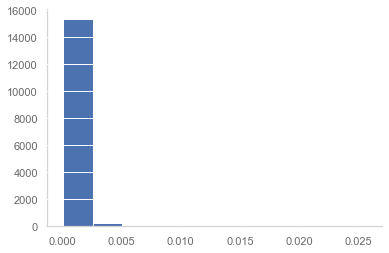

In [30]:
dfTFIDF_bodies_titles.mean(axis=0).hist()

La distribution des scores TFIDF est concentrée entre les valeurs 0 et 0.0025

In [31]:
# on ne garde que les token avec des TDFIDF significatif (>0.5)
df=dfTFIDFCommon[(dfTFIDFCommon.fillna(0))>0.01].fillna(0)
df.describe()

,fit,leaflet,generate,regular,distinguish,geocoding,coarser,subscription,textarea,mb,laravel,safest,powershell,oldfilesize,whats,viewmodel,ioc,choose,contains,workaround,la,el,revprop,thrown,controltemplate,...,pc,pwa,selectelement,mqtt,drm,time,rate,ajax,idea,perl,excerpt,whatsapp,work,jsp,sort,zone,cnn,child,auction,incrementally,south,linq,attribute,instant,wix
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.000310,0.000171,0.002360,0.001352,0.000227,0.000240,0.000256,0.000520,0.001068,0.000341,0.001586,0.000236,0.000972,0.000225,0.000438,0.000531,0.000287,0.000767,0.001285,0.000285,0.000190,0.000420,0.000170,0.000220,0.000287,...,0.000906,0.000279,0.000224,0.000317,0.000276,0.005788,0.000236,0.002576,0.001270,0.001875,0.000354,0.000254,0.010357,0.000897,0.002384,0.000445,0.000477,0.001603,0.000264,0.000209,0.000210,0.001627,0.002717,0.000416,0.000336
std,0.010294,0.007284,0.023990,0.021767,0.009691,0.010720,0.011467,0.015153,0.021915,0.012551,0.025809,0.010574,0.018498,0.010064,0.010748,0.014711,0.012833,0.016129,0.020033,0.009621,0.005891,0.011715,0.007594,0.007513,0.011506,...,0.020485,0.012469,0.010027,0.014163,0.012341,0.037000,0.007465,0.028468,0.013941,0.026766,0.014053,0.010434,0.048573,0.018482,0.029525,0.012999,0.012756,0.020269,0.011789,0.009338,0.008760,0.026254,0.026868,0.012397,0.010636
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.456583,0.325360,0.462071,0.469264,0.432883,0.479423,0.512831,0.512045,0.562692,0.554292,0.680518,0.472873,0.425406,0.450087,0.360693,0.519688,0.573926,0.467405,0.524080,0.425520,0.254256,0.457704,0.339636,0.333363,0.510581,...,0.621209,0.557610,0.448405,0.633397,0.551

In [32]:
dataPCA=df
dataPCA.info(),dataPCA.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2296 entries, fit to wix
dtypes: float64(2296)
memory usage: 35.0 MB


(None,
 Index(['fit', 'leaflet', 'generate', 'regular', 'distinguish', 'geocoding',
        'coarser', 'subscription', 'textarea', 'mb',
        ...
        'zone', 'cnn', 'child', 'auction', 'incrementally', 'south', 'linq',
        'attribute', 'instant', 'wix'],
       dtype='object', length=2296))

In [33]:
X=dataPCA.values
variables=dataPCA.columns # Variables

In [34]:
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)
XCentreReduit.shape

(2000, 2296)

In [35]:
n_comp=1700 # n_comp <= nombre de variables
pca = decomposition.PCA(n_components=n_comp)
pca.fit(XCentreReduit)

PCA(n_components=1700)

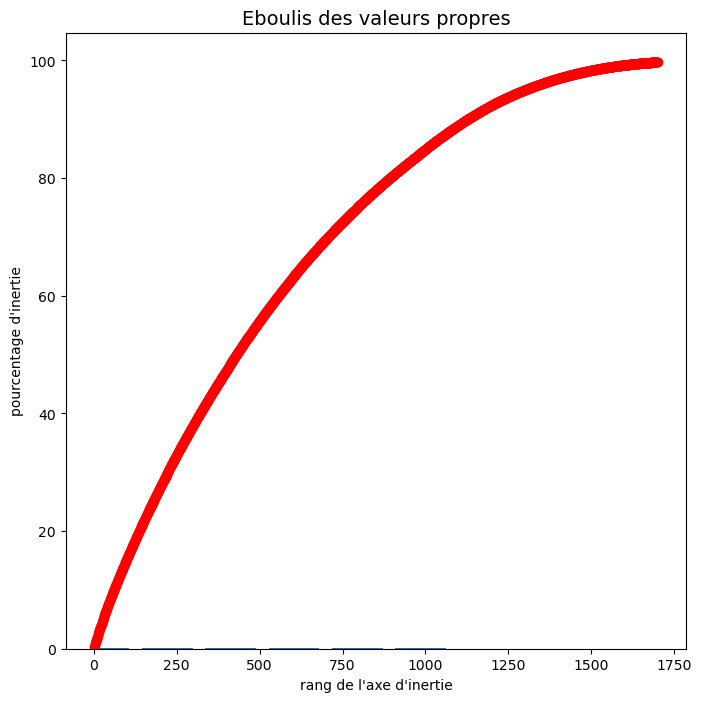

In [36]:
plt.style.use('default')
# taille du schema
plt.rcParams["figure.figsize"] = (8,8)

vectVarianceExpliquee = pca.explained_variance_ratio_*100 # renvoie les variences expliquées pour chacune des dimensions
plt.bar(np.arange(len(vectVarianceExpliquee))+1, vectVarianceExpliquee)
plt.plot(np.arange(len(vectVarianceExpliquee))+1, vectVarianceExpliquee.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres",fontsize=14,fontweight='normal')
plt.show()

In [37]:
composantesPrincipales = pca.components_ # triés par variance expliquée

In [38]:
# Selection du plan Factoriel
#dimension 1
d1=0
#dimension 2
d2=1

<timed exec>:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


CPU times: user 85.2 ms, sys: 16.6 ms, total: 102 ms
Wall time: 89.4 ms


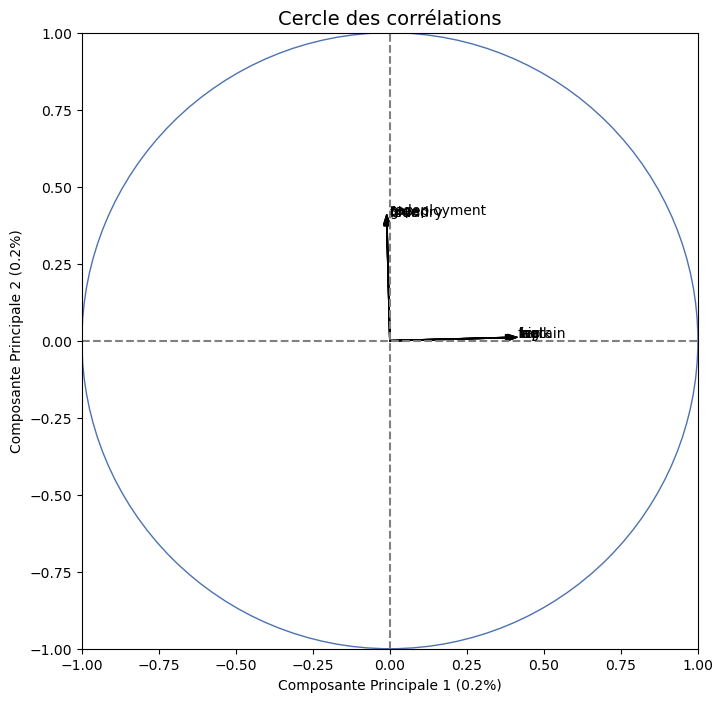

In [39]:
%%time
plt.style.use('default')
# taille du schema
plt.rcParams["figure.figsize"] = (8,8)

fig, ax = plt.subplots()

# configuration de la bordure
plt.xlim(-1,1)
plt.ylim(-1,1)

# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# libelles des axes
plt.xlabel('Composante Principale {} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
plt.ylabel('Composante Principale {} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
plt.title('Cercle des corrélations',color="black",fontsize=14,fontweight='normal')
# afficher le cercle
cercle = plt.Circle((0,0),radius=1, color='b', fill=False)
ax.set_aspect(1)
ax.add_patch(cercle)

    
#placement des étiquettes des p variables + fleches (partant du centre vers les points projetés)
for i in range(len(variables)):
    p=np.array([composantesPrincipales[d1][i],composantesPrincipales[d2][i]])
    # on utilise la distance euclidienne pour n'afficher les labels que pour les individus loin du centre
    distance= np.linalg.norm(p-np.array([0,0]))        
    if distance>0.35:
        plt.annotate(variables[i],xy =(composantesPrincipales[d1][i],composantesPrincipales[d2][i]),xytext =(composantesPrincipales[d1][i]+0.01,composantesPrincipales[d2][i]),arrowprops=dict(arrowstyle="-",
                                connectionstyle="arc3")) 
        plt.arrow(0,0,composantesPrincipales[d1][i],composantesPrincipales[d2][i].astype(np.float),length_includes_head=True,head_width=0.02, head_length=0.03,color="black")

In [40]:
composantesPrincipales[d1]

array([-0.00065124, -0.00086583, -0.00153534, ..., -0.00228819,
       -0.00041557, -0.00086883])

In [41]:
X.shape,composantesPrincipales[d1].shape,composantesPrincipales[d2].shape

((2000, 2296), (2296,), (2296,))

In [42]:
composantesPrincipales

array([[-0.00065124, -0.00086583, -0.00153534, ..., -0.00228819,
        -0.00041557, -0.00086883],
       [-0.00087834, -0.00092455, -0.00169323, ...,  0.00079021,
        -0.00076788, -0.00159481],
       [-0.00173265, -0.00232553,  0.00026113, ..., -0.00338737,
         0.00057009,  0.00550366],
       ...,
       [ 0.04086337, -0.00846016,  0.0120135 , ...,  0.00336209,
        -0.03027844,  0.00098579],
       [ 0.01805009, -0.01766276, -0.01487431, ...,  0.0439164 ,
         0.02568139, -0.02581493],
       [ 0.0006687 ,  0.01131646, -0.02804563, ..., -0.04533203,
         0.01221363, -0.00361086]])

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


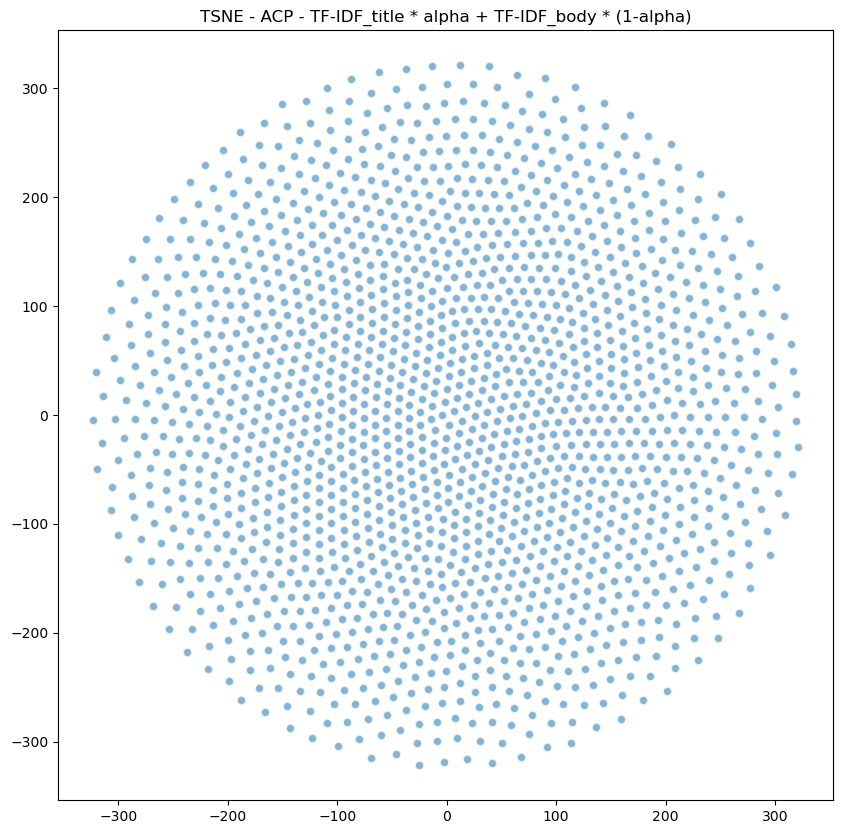

In [43]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(composantesPrincipales)
tsne_results.shape

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - ACP - TF-IDF_title * alpha + TF-IDF_body * (1-alpha)')
plt.show()

## CLUSTERING

In [44]:
X=df.values

### KMeans

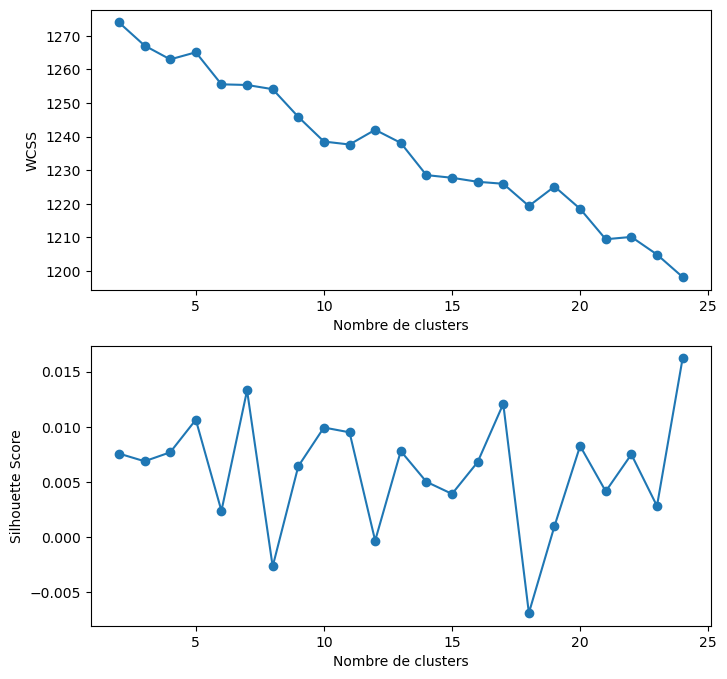

In [45]:
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]

for n in range(2,25):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,25), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,25), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Bi-grams

In [46]:
# application de TF IDF de scikit learn sur le document
pd.options.display.max_colwidth=1000
pd.options.display.max_columns=80

vectorizer= TfidfVectorizer(ngram_range = (2,2))

In [47]:
response= vectorizer.fit_transform(bodies)
dfTFIDF_bodies=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies=dfTFIDF_bodies.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF Bigrams - bodies - classement des mots')]

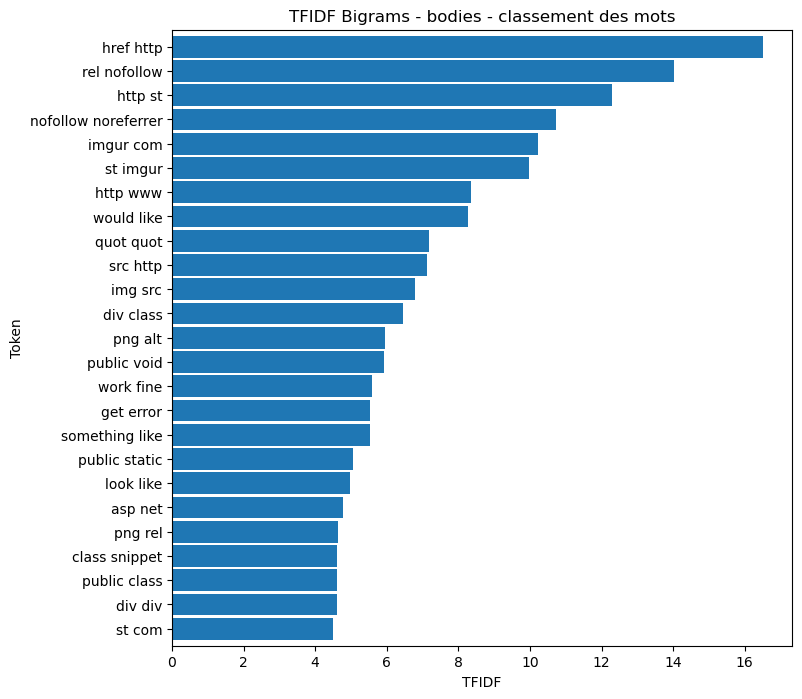

In [48]:
ax = sortedTFIDF_bodies.head(25).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF Bigrams - bodies - classement des mots')

In [49]:
response= vectorizer.fit_transform(titles)
dfTFIDF_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_titles=dfTFIDF_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF Bigrams - titles - classement des mots')]

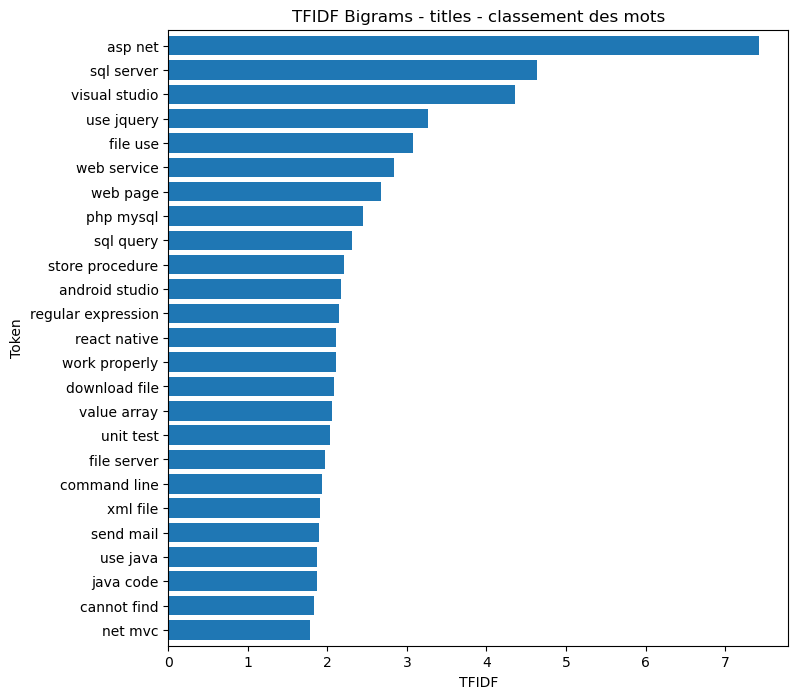

In [50]:
ax = sortedTFIDF_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF Bigrams - titles - classement des mots')

In [51]:
response= vectorizer.fit_transform(bodies_titles)
dfTFIDF_bodies_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies_titles=dfTFIDF_bodies_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF Bigrams - bodies+titles - classement des mots')]

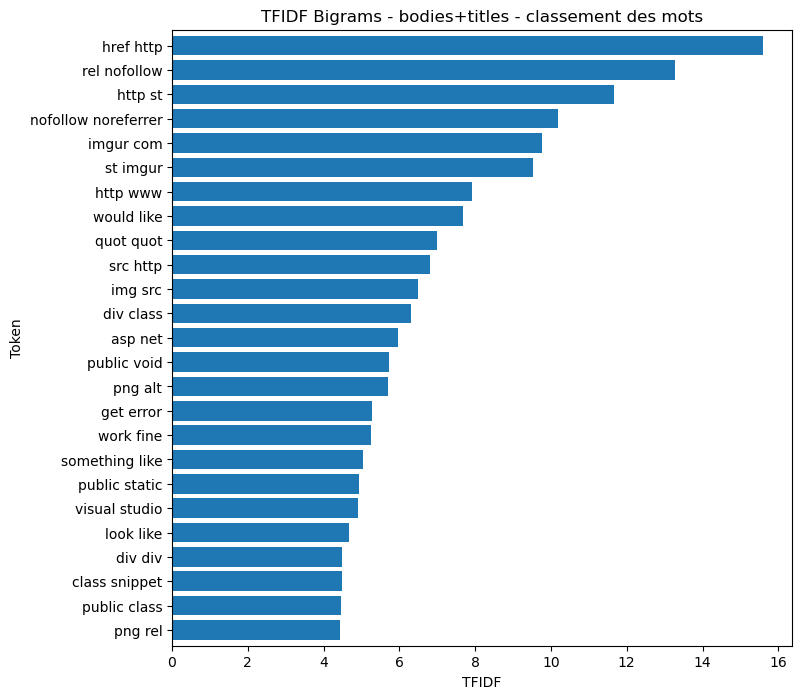

In [52]:
ax = sortedTFIDF_bodies_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF Bigrams - bodies+titles - classement des mots')

In [53]:
X=dfTFIDF_bodies_titles.values

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


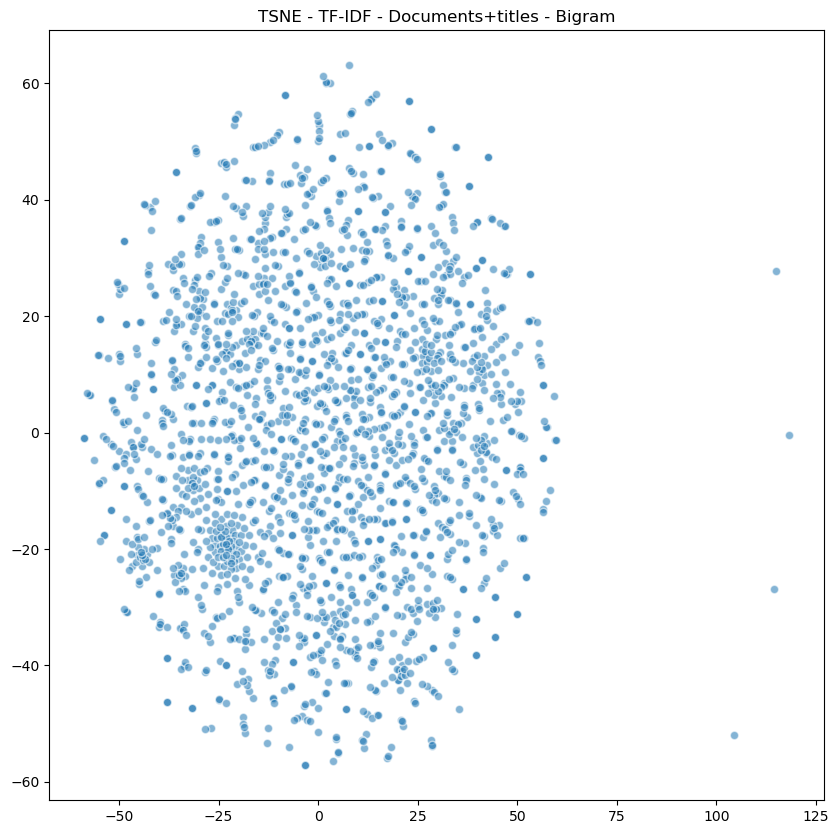

In [54]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)
tsne_results.shape

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF - Documents+titles - Bigram')
plt.show()

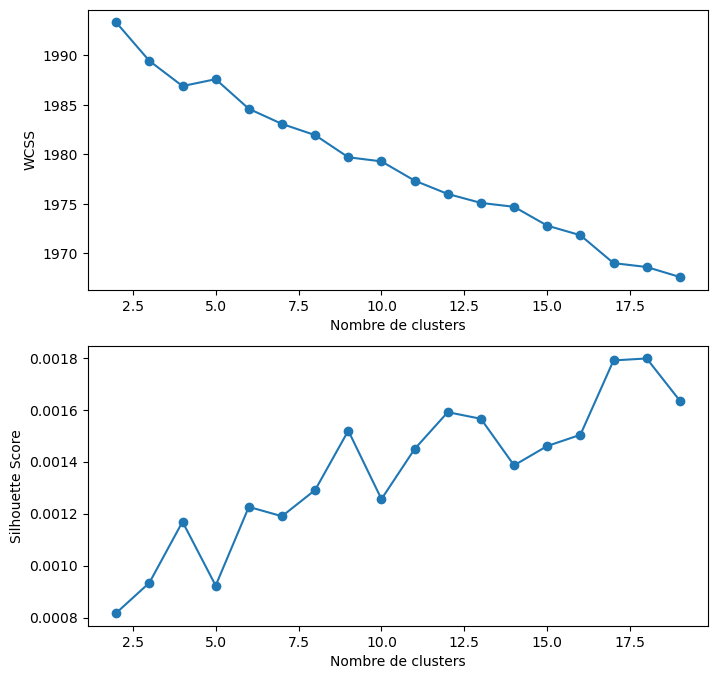

CPU times: user 2h 51min 57s, sys: 2min 20s, total: 2h 54min 18s
Wall time: 20min 2s


In [55]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]
#centreReduit = preprocessing.StandardScaler().fit(X)
#XCentreReduit = centreReduit.transform(X)

for n in range(2,20):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [56]:
commonTokens=list(set(dfTFIDF_titles.columns) & set(dfTFIDF_bodies.columns))
dfTFIDFCommon=dfTFIDF_titles[0:10000][commonTokens]*0.8+dfTFIDF_bodies[0:10000][commonTokens]*0.2
sortedTFIDFCommon=dfTFIDFCommon.sum(axis=0).sort_values(ascending=False)

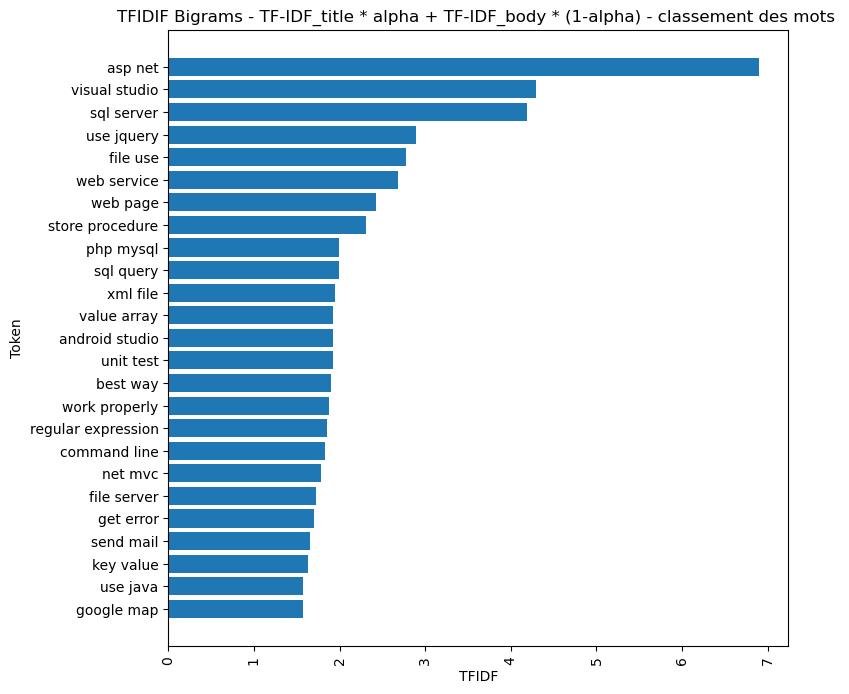

In [57]:
plt.figure(figsize=(8,8))

plt.barh(sortedTFIDFCommon.head(25).index,sortedTFIDFCommon.head(25).values)
plt.gca().invert_yaxis()

plt.xlabel("TFIDF")
plt.xticks(rotation='vertical')

plt.ylabel("Token")
plt.title("TFIDIF Bigrams - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - classement des mots ")
plt.show()

In [58]:
X=dfTFIDFCommon.values

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


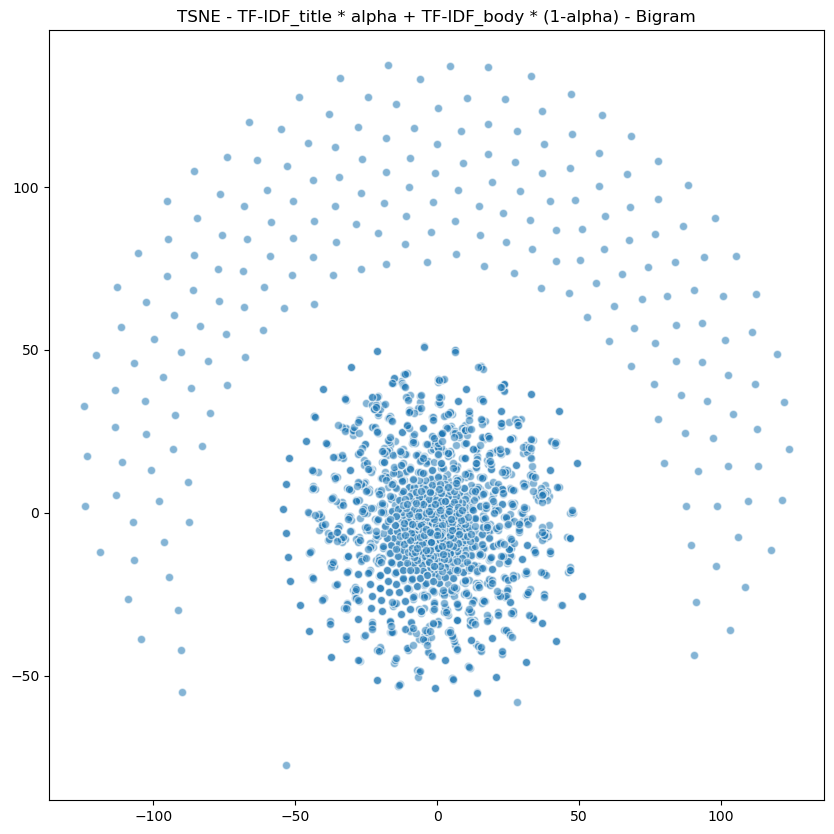

In [59]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - Bigram')
plt.show()

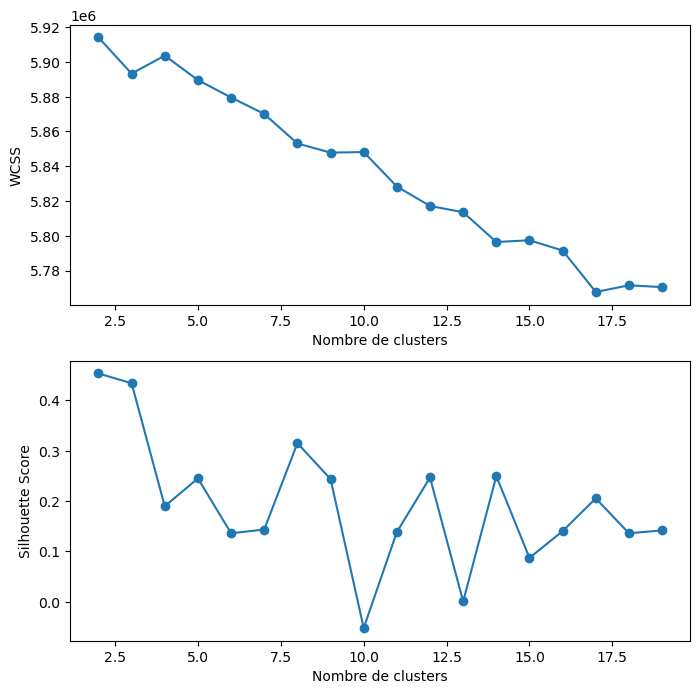

CPU times: user 2min 14s, sys: 2.32 s, total: 2min 16s
Wall time: 11.8 s


In [60]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)

for n in range(2,20):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(XCentreReduit)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(XCentreReduit,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Tri-grams

In [61]:
%%time
# application de TF IDF de scikit learn sur le document
pd.options.display.max_colwidth=1000
pd.options.display.max_columns=80

vectorizer= TfidfVectorizer(ngram_range = (3,3))



CPU times: user 8.51 ms, sys: 142 µs, total: 8.65 ms
Wall time: 2.9 ms


In [62]:
response= vectorizer.fit_transform(bodies)
dfTFIDF_bodies=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies=dfTFIDF_bodies.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TDFIDF Trigrams - bodies - classement des mots')]

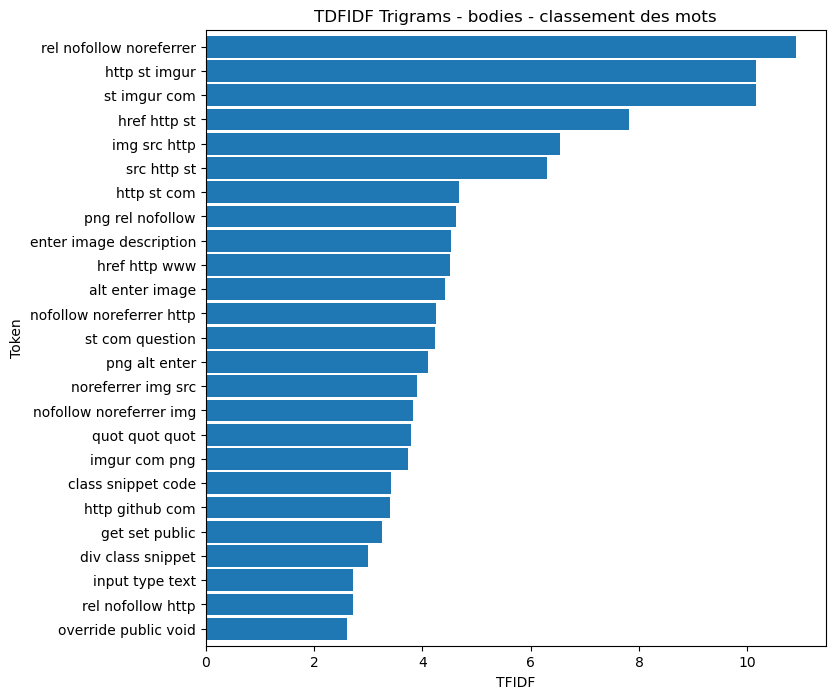

In [63]:
ax = sortedTFIDF_bodies.head(25).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TDFIDF Trigrams - bodies - classement des mots')

In [64]:
response= vectorizer.fit_transform(titles)
dfTFIDF_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_titles=dfTFIDF_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TDFIDF Trigrams - classement des mots')]

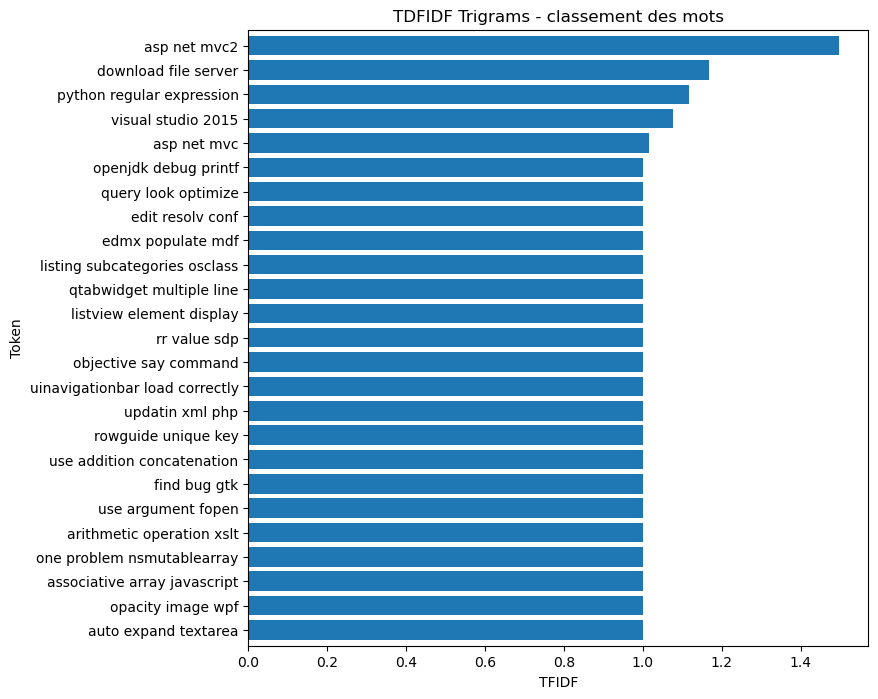

In [65]:
ax = sortedTFIDF_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TDFIDF Trigrams - classement des mots')

In [66]:
response= vectorizer.fit_transform(bodies_titles)
dfTFIDF_bodies_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies_titles=dfTFIDF_bodies_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TDFIDF Trigram - bodies+titles - classement des mots')]

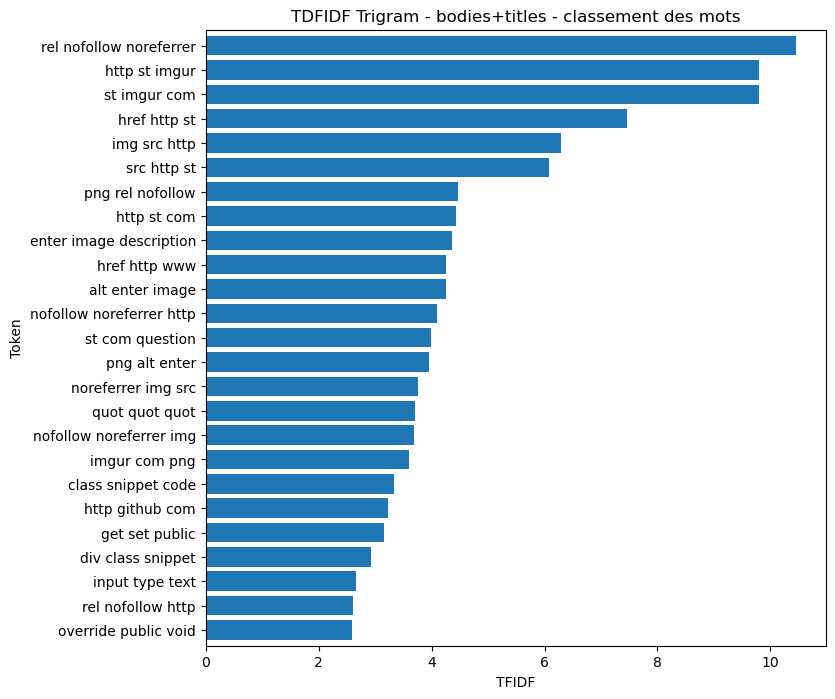

In [67]:
ax = sortedTFIDF_bodies_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TDFIDF Trigram - bodies+titles - classement des mots')

In [68]:
X=dfTFIDF_bodies_titles.values

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


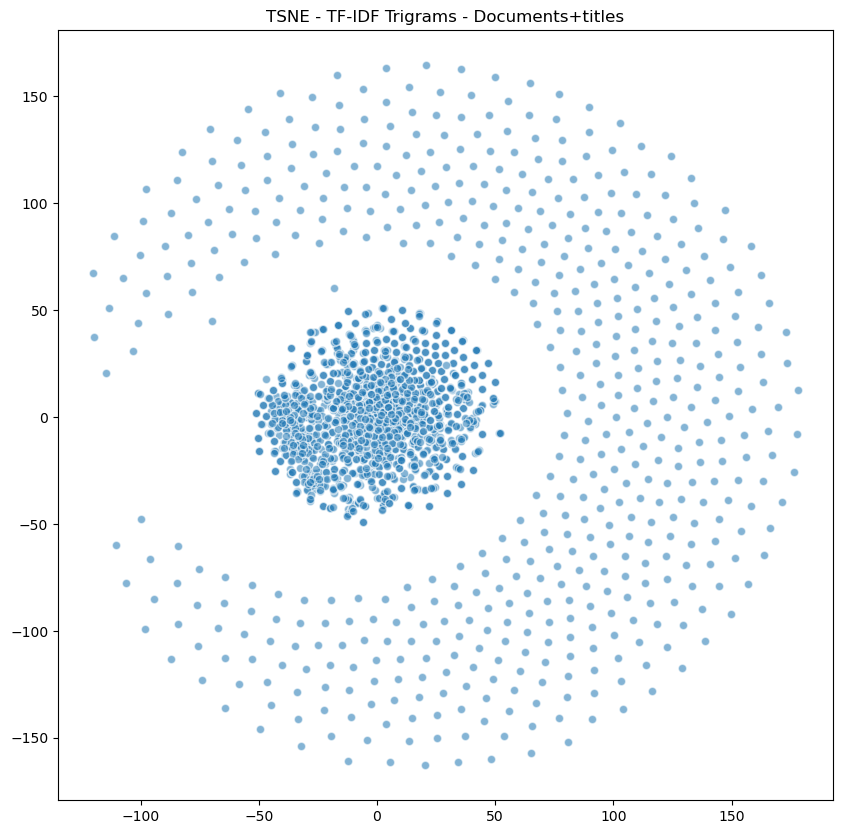

In [69]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)
tsne_results.shape

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF Trigrams - Documents+titles')
plt.show()

In [70]:
X.shape

(2000, 162819)

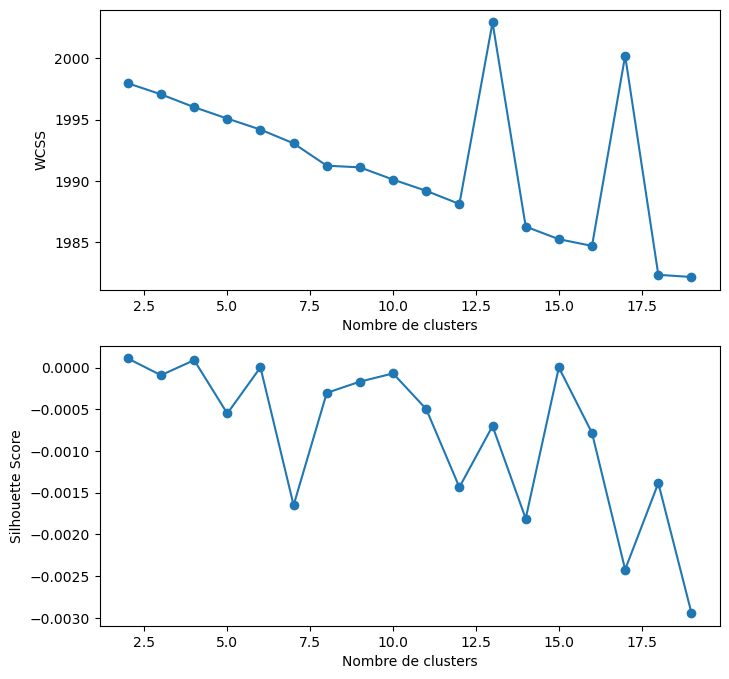

CPU times: user 30min 24s, sys: 45.7 s, total: 31min 10s
Wall time: 2min 51s


In [71]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]

for n in range(2,20):
    cl = cluster.MiniBatchKMeans(n_clusters=n, batch_size=10)# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [72]:
commonTokens=list(set(dfTFIDF_titles.columns) & set(dfTFIDF_bodies.columns))
dfTFIDFCommon=dfTFIDF_titles[0:10000][commonTokens]*0.8+dfTFIDF_bodies[0:10000][commonTokens]*0.2
sortedTFIDFCommon=dfTFIDFCommon.sum(axis=0).sort_values(ascending=False)

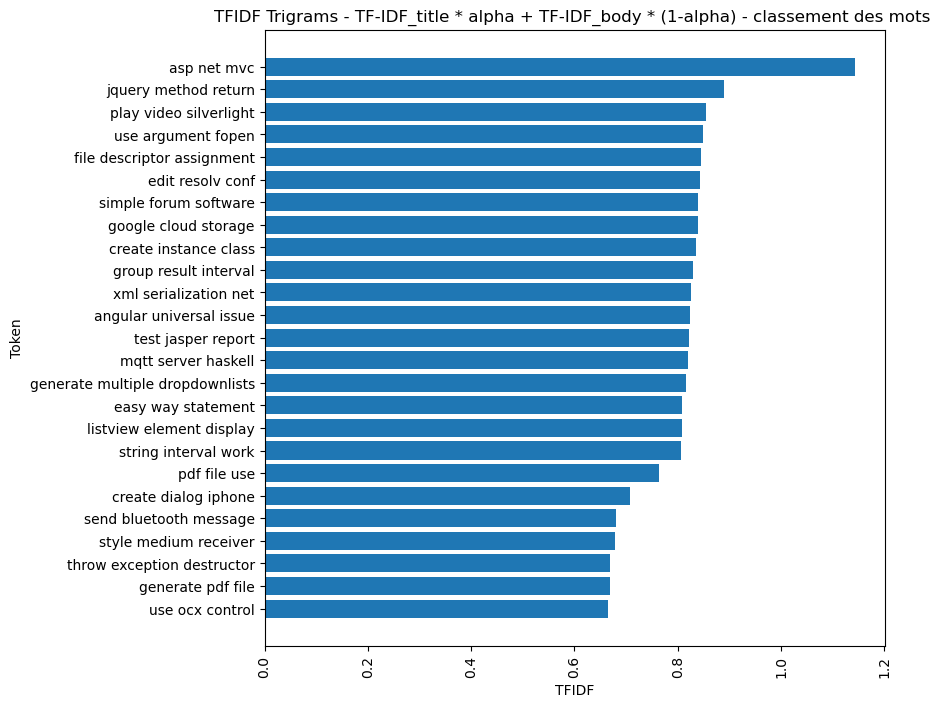

In [73]:
plt.figure(figsize=(8,8))

plt.barh(sortedTFIDFCommon.head(25).index,sortedTFIDFCommon.head(25).values)
plt.gca().invert_yaxis()

plt.xlabel("TFIDF")
plt.xticks(rotation='vertical')

plt.ylabel("Token")
plt.title("TFIDF Trigrams - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - classement des mots ")
plt.show()

In [74]:
X=dfTFIDFCommon

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


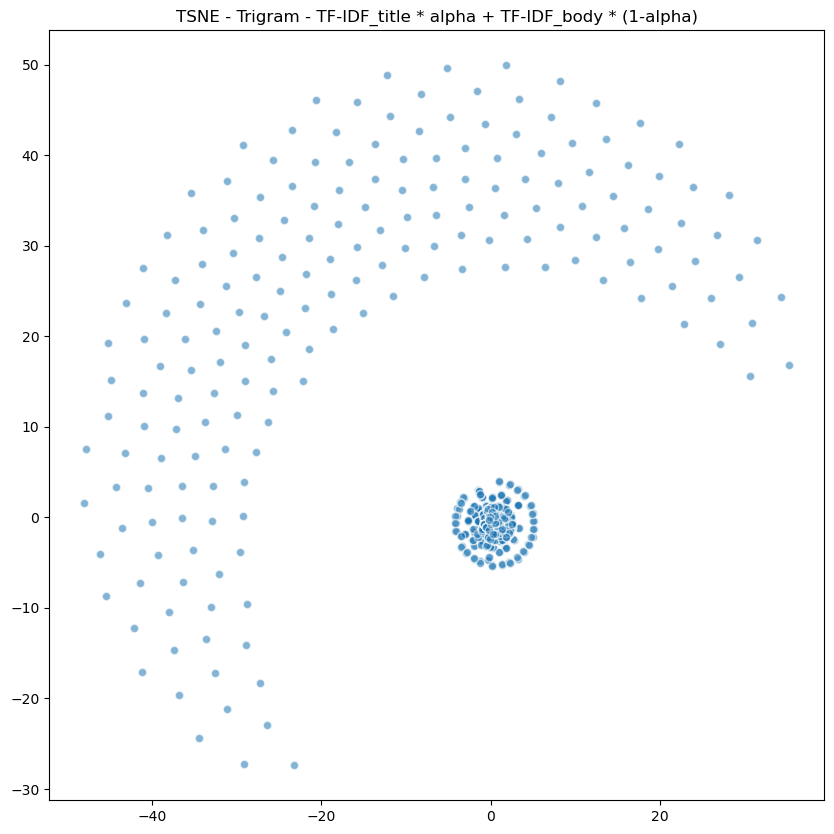

In [75]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - Trigram - TF-IDF_title * alpha + TF-IDF_body * (1-alpha)')
plt.show()

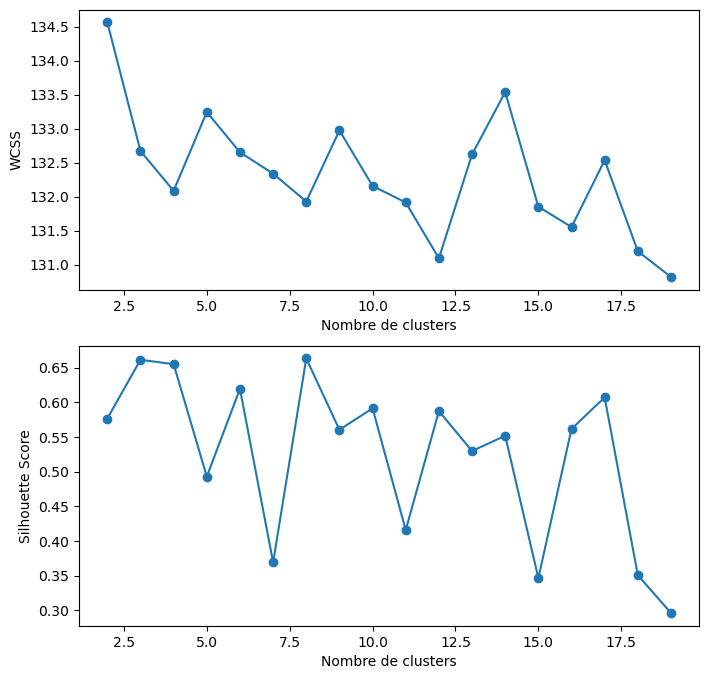

CPU times: user 26.6 s, sys: 910 ms, total: 27.5 s
Wall time: 2.44 s


In [76]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]

for n in range(2,20):
    cl = cluster.MiniBatchKMeans(n_clusters=n, batch_size=10)# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Tags

In [77]:
tags=dfCleaned['Tags'].map(''.join)
tags

43576                                  c#  custom-controls  propertygrid  inplace-editing 
24783                                                      javascript  jquery  codemirror 
27941                                                      php  mysql  zend-search-lucene 
31045                                                                  javascript  jquery 
11525                                                 symfony  session  cookies  samesite 
35342                                                                 php  iis-7  caching 
5189                                                                angular  ng-bootstrap 
33560                                                                         c#  casting 
17916                                                                             jsf  el 
45286                                                               c#  screenshot  frame 
17193          azure-devops  azure-pipelines  azure-pipelines-tasks  azure-pipelines-yaml 

## Classement TF-IDF

In [78]:
vectorizer= TfidfVectorizer()

In [79]:
response= vectorizer.fit_transform(tags)
dfTFIDF_tags=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_tags=dfTFIDF_tags.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - tags - classement des mots')]

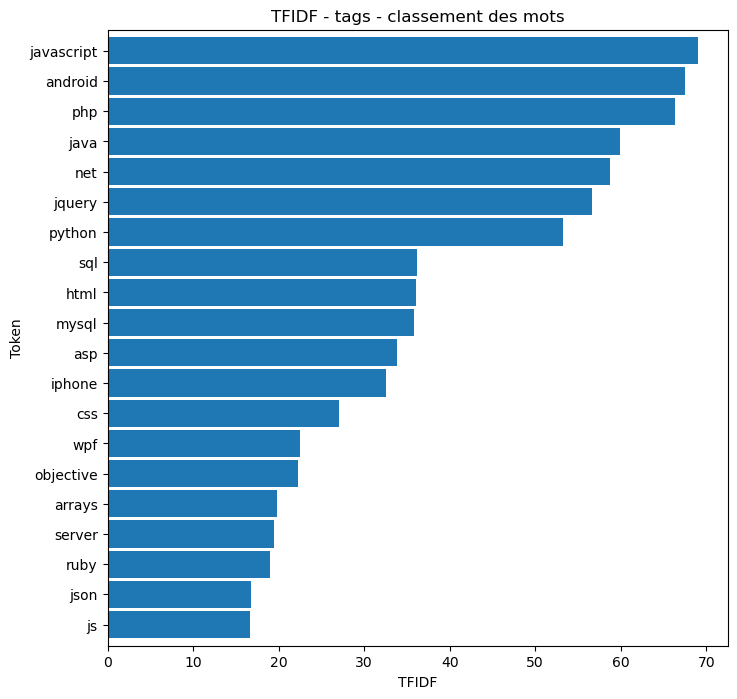

In [80]:
ax = sortedTFIDF_tags.head(20).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - tags - classement des mots')

## Labellisation

In [81]:
# correspondance Tag -> classe (0->20)
tagclass=sortedTFIDF_tags.head(20).to_dict()
for i, k in enumerate(tagclass):
    tagclass[k]=i
tagclass

{'javascript': 0,
 'android': 1,
 'php': 2,
 'java': 3,
 'net': 4,
 'jquery': 5,
 'python': 6,
 'sql': 7,
 'html': 8,
 'mysql': 9,
 'asp': 10,
 'iphone': 11,
 'css': 12,
 'wpf': 13,
 'objective': 14,
 'arrays': 15,
 'server': 16,
 'ruby': 17,
 'json': 18,
 'js': 19}

Voici les 20 tags les plus utilisés.
Que nous utiliserons comme target.

In [82]:
dfTFIDFCommon.columns

Index(['create border text', 'angular library umdmoduleids',
       'possible orientation cube', 'style medium receiver',
       'dependency express field', 'javascript java servlet', 'tfs send mail',
       'restcontroller method endpoint', 'web service asp', 'video take full',
       ...
       'different content source', 'go pear php',
       'java util missingresourceexception', 'unsigned mysql default',
       'service resource group', 'internal save file',
       'definition particular jsp', 'token recognize json',
       'pythonic way check', 'run script browser'],
      dtype='object', length=723)

In [83]:
cols=[]
for i,k in enumerate(tagclass):
    regexstring='.*'+k+'.*' # on recherche les chaines contenant le tag k
    cols = cols+[c for c in dfTFIDFCommon.columns if re.match(regexstring,c.lower())] # si le tag est trouvé on ajoute la colonne à notre liste de colonnes à conserver
cols=list(set(cols))

In [84]:
dfTFIDFCommonTarget=dfTFIDFCommon[cols]
dfTFIDFCommonTarget.sample(8)

,url use jquery,mvc net core,javascript java servlet,web service asp,java ee api,type sql statement,launcher exception java,execute statement sql,microsoft search server,manipulate parse json,asp net mvc,service asp net,asp net core,javascript array array,version net framework,server error ps,border android text,error ps net,html twig file,search android market,array javascript java,create dialog iphone,setting via puphpet,java net urlconnection,delayed job asp,web service python,ljava lang object,import url jsp,convert sql query,type authorization net,test jasper report,inside another html,main java lang,server error production,top border android,authorization net mvc,stingray objective toolkit,subnet mask rout,host prebid server,height screen android,...,mysql field primary,test java swing,array convert python,internal server error,gprs internet connection,instance ironpython class,sql server use,define unsigned mysql,server work amp,drop list json,image mvc net,ml server client,equivalent sql server,php multidimensional array,java servlet use,php generate input,use jquery cycle,android studio create,job asp net,gzip javascript file,json file use,printing html form,use single mysql,sql query spark,new java program,statement sql constraint,path live server,internet connection error,recognize json content,jquery cycle plugin,big html string,go pear php,java util missingresourceexception,unsigned mysql default,android text view,definition particular jsp,token recognize json,pythonic way check,create instance ironpython,microsoft ml server
1702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [85]:
# DEBUG
row=dfTFIDFCommonTarget.iloc[128]
def getClass(row):
    # no de colonne ayant le TFIDF max
    if row.max()==0: # TF IDF nul pour toute la ligne
        return -1
    else:
        tags=row.idxmax().split() #separation du bigramme
        print(tags)
        rowclass=tagclass.get(tags[0],-1)
        if rowclass<0:
            print('row negative')
            rowclass=tagclass.get(tags[1],-1)
        return rowclass
print(getClass(row))

-1


In [86]:
dfTFIDFCommonTarget.iloc[812].idxmax()

'url use jquery'

# Modelisation

In [87]:
X=dfTFIDFCommon.values

In [88]:
y=dfTFIDFCommonTarget.apply(lambda row:getClass(row),axis=1)

['version', 'net', 'framework']
row negative
['launch', 'android', 'studio']
row negative
['java', 'net', 'urlconnection']
['height', 'screen', 'android']
row negative
['java', 'lang', 'noclassdeffounderror']
['user', 'define', 'python']
row negative
['php', 'generate', 'input']
['url', 'use', 'jquery']
row negative
['optimize', 'mysql', 'query']
row negative
['use', 'jquery', 'ajax']
row negative
['ml', 'server', 'client']
row negative
['array', 'convert', 'python']
row negative
['detect', 'server', 'run']
row negative
['test', 'jasper', 'report']
row negative
['ignore', 'html', 'tag']
row negative
['setting', 'via', 'puphpet']
row negative
['pdf', 'file', 'json']
row negative
['xml', 'serialization', 'net']
row negative
['use', 'single', 'mysql']
row negative
['asp', 'net', 'mvc']
['web', 'service', 'asp']
row negative
['java', 'net', 'urlconnection']
['mqtt', 'server', 'haskell']
row negative
['sql', 'constraint', 'primary']
['create', 'dialog', 'iphone']
row negative
['server', 'er

<AxesSubplot:>

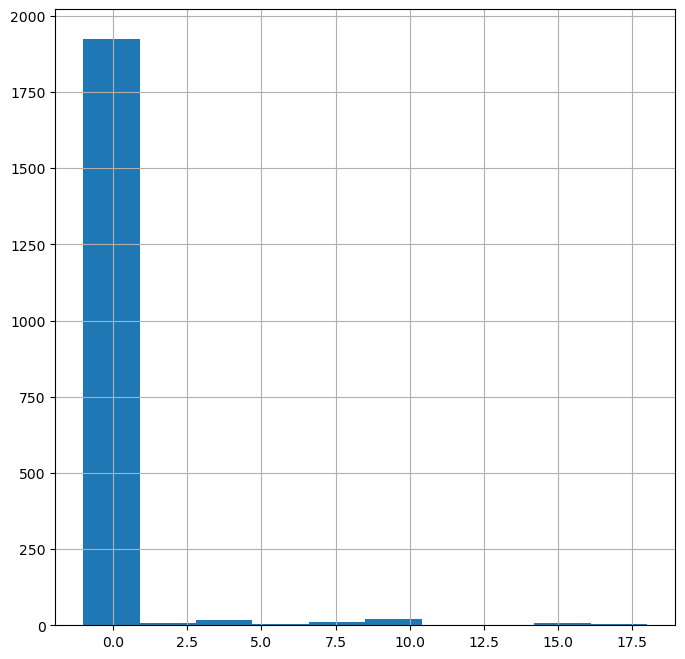

In [89]:
# distribution des tags, on constate une representation important sur les php, java, net
y.hist()

In [90]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state = 49)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1400, 723), (600, 723), (1400,), (600,))

In [91]:
from sklearn.ensemble import RandomForestRegressor

randomForest=RandomForestRegressor(n_estimators = 100,
                           min_samples_split = 2,
                           n_jobs = -1)

In [92]:
np.unique(y_train)

array([-1,  0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 14, 16, 18])

In [93]:
y_train

1636   -1
897    -1
60     -1
905    -1
37     -1
1145   -1
796    -1
1934   -1
1862   -1
1742   -1
686    -1
974    -1
       ..
892    -1
638    -1
1925   -1
453    -1
908    -1
1906   -1
1780   -1
1206   -1
1525   -1
424    -1
1709   -1
426    -1
Length: 1400, dtype: int64

## Bayes naïf

In [94]:
NaiveBayes = naive_bayes.GaussianNB().fit(X_train, y_train)
y_pred_train=NaiveBayes.predict(X_train)
y_pred_test=NaiveBayes.predict(X_test)
y_pred_train.shape,y_pred_test.shape

((1400,), (600,))

In [95]:
np.unique(y_pred_train)

array([-1,  0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 14, 16, 18])

In [96]:
# scores exactitude, r2
accuracy = accuracy_score(y_test, y_pred_test) 
r2 = r2_score(y_test,y_pred_test)
accuracy, r2

(0.058333333333333334, -6.000207874277636)

In [97]:
np.unique(y_test), np.unique(y_pred_test)

(array([-1,  0,  1,  3,  5,  6,  7,  8, 10, 16, 18]),
 array([-1,  1,  2,  3,  4,  5,  7,  8, 10, 16]))

In [100]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion.sort_values(by='Class')

KeyError: 2

## Random forest

In [101]:
from sklearn.ensemble import RandomForestClassifier

In [102]:
rfc = RandomForestClassifier(random_state=0)

rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [103]:
y_pred_train=rfc.predict(X_train)
y_pred_test=rfc.predict(X_test)
np.unique(y_pred_train)

array([-1,  0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 14, 16, 18])

In [104]:
# scores exactitude, r2
accuracy = accuracy_score(y_test, y_pred_test) 
r2 = r2_score(y_test,y_pred_test)
accuracy, r2

(0.9666666666666667, 0.3693925913607451)

In [105]:
y_test.shape,y_pred_test.shape

((600,), (600,))

In [106]:
np.unique(y_test), np.unique(y_pred_test)

(array([-1,  0,  1,  3,  5,  6,  7,  8, 10, 16, 18]), array([-1,  5, 10, 16]))

In [107]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion.sort_values(by='Class')

,Class,TP,FP,TN,FN,TPR,FPR,Accuracy
0,-1,571,19,0,1,0.998252,1.000000,0.966159
1,5,1,0,570,1,0.500000,0.000000,0.998252
2,10,6,1,565,0,1.000000,0.001767,0.998252
3,16,2,0,569,2,0.500000,0.000000,0.996510


In [108]:
from xgboost import XGBClassifier

model=XGBClassifier(eta=0.1,n_estimators=100,max_depth=4,subsample=1,colsample_bytree=0.8,objective='multi:softmax')
model.fit(X_train,y_train)

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:10:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eta=0.1, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [109]:
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)
np.unique(y_pred_train)

array([-1, 10])

In [110]:
# scores exactitude, r2
accuracy = accuracy_score(y_test, y_pred_test) 
r2 = r2_score(y_test,y_pred_test)
accuracy, r2

(0.9583333333333334, 0.0846879807092672)

In [111]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion.sort_values(by='Class')

,Class,TP,FP,TN,FN,TPR,FPR,Accuracy
0,-1,571,24,0,1,0.998252,1.000000,0.958054
1,10,4,1,567,2,0.666667,0.001761,0.994774


# LDA

In [ ]:
# Vectorize document using TF-IDF
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenize)

# Fit and Transform the documents
train_data = tfidf.fit_transform(documents)
train_data

In [ ]:
# Define the number of topics or components
num_components=20

# Create LDA object
model=LatentDirichletAllocation(n_components=num_components)

# Fit and Transform SVD model on data
lda_matrix = model.fit_transform(train_data)

# Get Components 
lda_components=model.components_

# Print the topics with their terms
terms = tfidf.get_feature_names()

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)